<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  FINAL PROJECT – Introduction to Data Science
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Data Modelling
</div>

<div style="text-align: left; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Regression
</div>

<font color=lightgreen>**Context**</font>: In this section, OLS Linear Regression and DecisionTreeRegressor are chosen for machine learning.

<font color=lightgreen>**Question**</font>: Training a model to predict Total revenue.

<font color=lightgreen>**Overall**</font>: We will train 02 models and compare its MAE.

## Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline

## Data preparation

Firstly, we will drop 02 columns (year and country) as well as drop "GDP in USD" column for y (prediction)

In [2]:
# YOUR CODE HERE (OPTION) 
ori_data = pd.read_csv("./data/remove_outlier.csv")
copy_data = ori_data.copy()

In [3]:
def get_object_columns(dataframe):
    object_columns = dataframe.select_dtypes(include=['object']).columns
    return object_columns

object_columns = get_object_columns(copy_data)
#rem_cols = object_columns.difference(['city', 'state'])

print(object_columns)

copy_data.drop(object_columns, axis='columns', inplace=True)

Index(['name', 'street_address', 'city', 'state', 'urban_location_f',
       'memb_counc_teach_hosps_f', 'county', 'form_990_filed_part_grp_ret_f',
       'chna_cond_w_mult_hosp_facilities_f',
       'st_impl_aca_medcd_exp_cvrg_adlts_w_incs_up_138pct_fpl_f',
       'st_law_req_hosp_rpt_comm_bnfts_f'],
      dtype='object')


In [4]:
for col in copy_data.columns[:-3]:
    median = copy_data[col].median(skipna=True)
    copy_data[col] = copy_data[col].fillna(median)
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487 entries, 0 to 3486
Data columns (total 26 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   hospital_id                                          3487 non-null   int64  
 1   ein                                                  3487 non-null   int64  
 2   hospital_bed_count                                   3487 non-null   int64  
 3   medicare_provider_number                             3487 non-null   int64  
 4   fiscal_yr                                            3487 non-null   int64  
 5   form_990_num_fac_oper                                3487 non-null   int64  
 6   tot_func_exp                                         3487 non-null   int64  
 7   tot_revenue                                          3487 non-null   int64  
 8   tot_comm_bnfts                                       3487 non-null  

In [5]:
cols_at_end = ['tot_revenue']
copy_data = copy_data[[c for c in copy_data if c not in cols_at_end] 
        + [c for c in cols_at_end if c in copy_data]]

copy_data

,hospital_id,ein,hospital_bed_count,medicare_provider_number,fiscal_yr,form_990_num_fac_oper,tot_func_exp,tot_comm_bnfts,chrty_care,unreim_medcd,...,comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct,bad_debt_tot_func_exp_pct,mdcre_shrtfl_tot_func_exp_pct,rat_pat_care_npat_care_comm_bnfts,per_capita_inc,med_hsehld_inc,percent_ppl_pov_pct,percent_ppl_65_yrs_old_without_hlth_insr_pct,unemp_rate_16_yrs_older,tot_revenue
0,1,630307951,99,10007,2021,1,24548253,399634,390047,0,...,0.026311,13.718381,5.171236,40.684990,37930,43544,17.1,12.5,3.0,26350803
1,2,630578923,362,10011,2021,1,269655098,14530957,7786731,3709342,...,0.070801,1.065159,-3.886520,3.787978,58424,57802,14.4,10.7,3.6,247421803
2,3,630312913,252,10016,2021,5,6138054,6276227,2384449,2159588,...,3.608961,86.370077,-31.212172,2.623290,59588,88444,7.0,8.7,2.1,18093135
3,4,630459034,106,10018,2012,1,7281976,848514,388457,591705,...,0.000000,1.481425,-50.256895,-6.042335,45622,43967,18.6,14.5,6.8,7873057
4,5,581973570,60,10022,2021,2,336272925,21995495,10698494,10424636,...,0.000000,3.750702,-9.018449,24.213638,37869,50388,14.7,13.0,2.5,261011061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,3487,813040663,16,670136,2021,3,97887005,9631051,5837817,3329327,...,0.047066,9.919405,-5.886450,21.891776,74032,82605,10.2,16.5,4.0,96294245
3483,3488,741109643,7,670143,2021,14,2379013884,179871173,92346125,19362751,...,0.617975,2.104334,-5.398501,1.638866,42177,74612,10.8,22.7,4.5,2846977586
3484,3489,831954982,63,670260,2021,1,121669224,5122144,1889262,2590087,...,0.276952,12.712880,-3.221224,6.968550,63283,90880,6.9,13.4,4.4,130956692
3485,3490,750800661,46,670300,2021,9,1636296370,222654822,113088223,42316006,...,0.115922,14.660452,-1.924540,2.310823,49333,79849,7.9,18.9,4.5,1856448774


In [6]:
y = copy_data["tot_revenue"]
y

0         26350803
1        247421803
2         18093135
3          7873057
4        261011061
           ...    
3482      96294245
3483    2846977586
3484     130956692
3485    1856448774
3486      33017334
Name: tot_revenue, Length: 3487, dtype: int64

In [7]:
copy_data.drop(["tot_revenue"], inplace=True, axis='columns')
copy_data
X = copy_data

Secondly, we will spilt it into 02 data sets (train and test)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)


In [9]:
X_train.head()

,hospital_id,ein,hospital_bed_count,medicare_provider_number,fiscal_yr,form_990_num_fac_oper,tot_func_exp,tot_comm_bnfts,chrty_care,unreim_medcd,...,unreim_medcd_tot_func_exp_pct,comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct,bad_debt_tot_func_exp_pct,mdcre_shrtfl_tot_func_exp_pct,rat_pat_care_npat_care_comm_bnfts,per_capita_inc,med_hsehld_inc,percent_ppl_pov_pct,percent_ppl_65_yrs_old_without_hlth_insr_pct,unemp_rate_16_yrs_older
3069,3074,452230827,20,451349,2021,1,12270744,572539,493755,0,...,0.000000,0.592515,12.597826,-1.615965,6.267199,53734,39897,19.6,26.3,4.9
2415,2418,300047074,8,360271,2012,1,11941775,214205,158289,55916,...,0.468239,0.000000,2.800254,3.232945,2.535992,38299,55599,14.0,13.3,7.1
304,306,951656366,408,50471,2021,1,435725358,57964159,4869318,47662885,...,10.938745,0.701364,0.174833,-3.052137,9.670955,68272,75624,13.2,11.1,8.9
3262,3267,550440086,201,510012,2021,1,72941895,8771400,0,8771400,...,12.025188,0.000000,6.925565,-0.271982,2.535992,37641,44307,17.1,7.0,5.5
3472,3477,203749695,8,670087,2018,2,325774991,19297833,8412355,0,...,0.000000,0.044986,6.120837,-4.263144,0.790949,50776,87817,6.4,12.4,3.1


In [10]:
y_train.head()

3069     14608197
2415     12662282
304     435921447
3262     56093599
3472    385770943
Name: tot_revenue, dtype: int64

In [11]:
X_test.head()

,hospital_id,ein,hospital_bed_count,medicare_provider_number,fiscal_yr,form_990_num_fac_oper,tot_func_exp,tot_comm_bnfts,chrty_care,unreim_medcd,...,unreim_medcd_tot_func_exp_pct,comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct,bad_debt_tot_func_exp_pct,mdcre_shrtfl_tot_func_exp_pct,rat_pat_care_npat_care_comm_bnfts,per_capita_inc,med_hsehld_inc,percent_ppl_pov_pct,percent_ppl_65_yrs_old_without_hlth_insr_pct,unemp_rate_16_yrs_older
1739,1741,453808607,35,261326,2011,1,38156630,1525905,183827,1298132,...,3.402114,0.000000,0.000000,0.000000,33.722273,29709,39359,16.8,20.4,7.7
2984,2989,760436439,66,450395,2021,1,52298954,1781364,1766934,0,...,0.000000,0.000000,22.916552,-1.225084,122.448649,42830,47535,15.0,23.0,8.0
2473,2476,731034824,876,370028,2021,1,1074469038,63669344,19622860,37843929,...,3.522105,0.023566,0.694095,-2.362171,9.265019,56971,55332,15.2,16.5,4.1
1343,1345,42103584,31,220050,2015,1,23335058,2044006,577531,1300960,...,5.575131,0.704147,1.174092,-5.262314,11.439710,48189,60853,15.3,2.7,4.4
2798,2801,460224598,109,430014,2021,1,210130543,8188525,923597,4103747,...,1.952951,0.002933,4.116893,-2.872417,1.684317,62587,64993,9.1,12.2,3.0


In [12]:
y_test.head()

1739      38995801
2984      52265732
2473    1085953671
1343      21816510
2798     210216713
Name: tot_revenue, dtype: int64

## Feature engineering

We will find some good features for training

### Model 1: using some tools

Firstly, we will eleminate some redundant by repeated-KFold

In [13]:
avg_mutual = 0
for i in range(5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

    grid = dict()
    grid['sel__k'] = [i for i in range(X_train.shape[1]-20, X_train.shape[1]+1)]

    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

    results = search.fit(X_train, y_train)

    #print('Best MAE: %.3f' % results.best_score_)
    best_config = results.best_params_
    best_sel_k = best_config['sel__k']
    avg_mutual += int(best_sel_k)
print('Best Config for mutual: %s' % int(avg_mutual / 5))
#############################################################

avg_col = 0
for i in range(5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    model = LinearRegression()
    fs = SelectKBest(score_func=f_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

    grid = dict()
    grid['sel__k'] = [i for i in range(X_train.shape[1]-20, X_train.shape[1]+1)]

    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

    results = search.fit(X_train, y_train)

    #print('Best MAE: %.3f' % results.best_score_)
    best_config = results.best_params_
    best_sel_k = best_config['sel__k']
    avg_col += int(best_sel_k)
print('Best Config for correlation: %s' % int(avg_col / 5))

Best Config for mutual: 13
Best Config for correlation: 25


In [14]:
# avg_mutual = 11
# avg_col = 25

Secondly, we will find 03 features

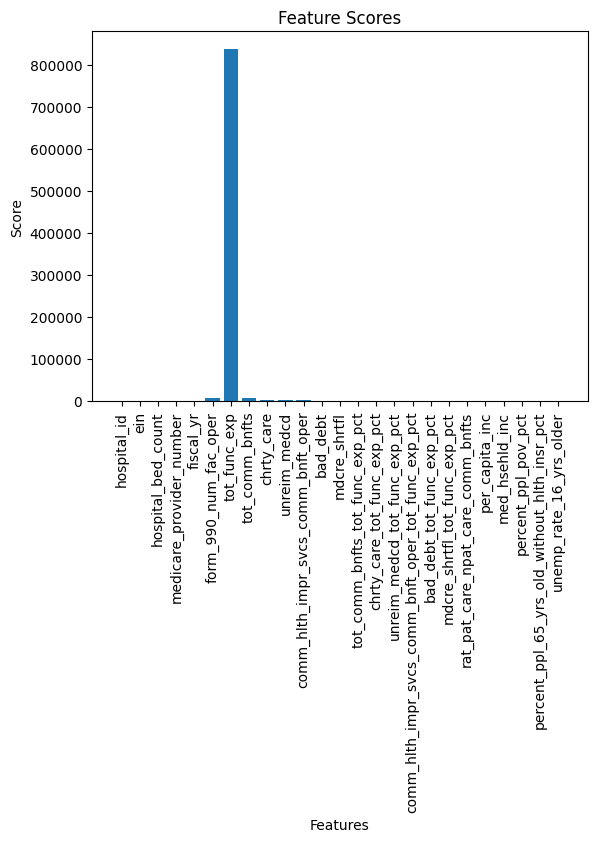

In [15]:
def select_features(X_train, y_train, X_test):

 fs = SelectKBest(score_func=f_regression, k=int(avg_col / 5))

 fs.fit(X_train, y_train)

 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_names = X_train.columns

plt.bar(range(len(fs.scores_)), fs.scores_)

plt.xticks(range(len(fs.scores_)), feature_names, rotation='vertical')

plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Scores')

plt.show()

So, tot_func_exp is the first one.

In [16]:
mae_1 = {}
for i in X_train.columns:
    tree = DecisionTreeRegressor(random_state=23)
    tree.fit(X_train[[i]], y_train)
    
    # prediction
    y_pred = tree.predict(X_test[[i]])
    
    # compute the regression evaluation metric, e.g., Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    
    mae_1[i] = mae
best_skill = min(mae_1, key=mae_1.get)
print(f"Best Skill: {best_skill}")
print(f"MAE for Best Skill: {mae_1[best_skill]}")


Best Skill: tot_func_exp
MAE for Best Skill: 22621030.761103153


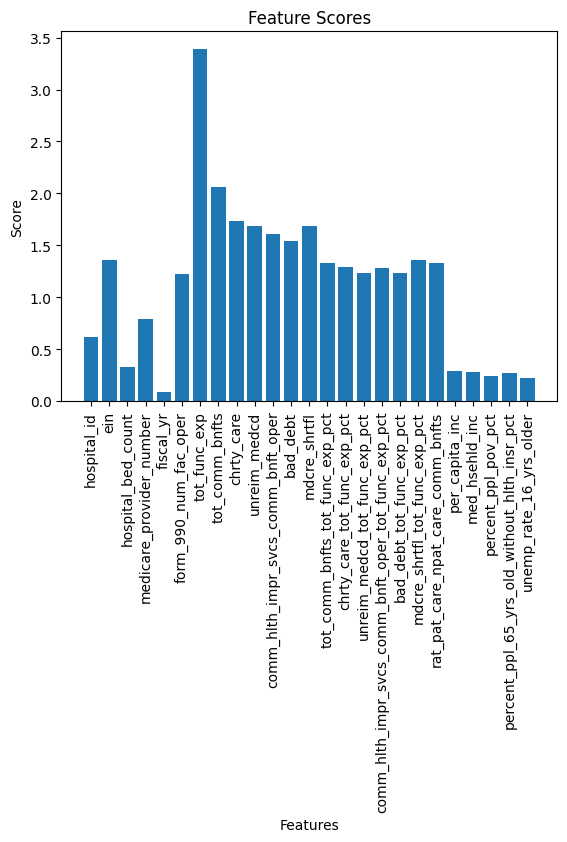

In [17]:
def select_features(X_train, y_train, X_test):

 fs = SelectKBest(score_func=mutual_info_regression, k=int(avg_mutual / 5))

 fs.fit(X_train, y_train)

 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

feature_names = X_train.columns

plt.bar(range(len(fs.scores_)), fs.scores_)

plt.xticks(range(len(fs.scores_)), feature_names, rotation='vertical')

plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Scores')

plt.show()

Finally, tot_comm_bnfts is the last one.

### Model 2: We will choose some features based on the correlation in file eda.ipynb

## Training model

In [18]:
X_final_1_train = X_train[['tot_func_exp', 'tot_comm_bnfts']]
X_final_1_test = X_test[['tot_func_exp', 'tot_comm_bnfts']]

X_final_2_train = pd.concat([X_train[['tot_func_exp']] * 1, X_train[['mdcre_shrtfl']]*(-0.52), X_train[['form_990_num_fac_oper']]*(0.86), X_train[['tot_comm_bnfts']]*(0.84)], axis=1)
X_final_2_test = pd.concat([X_test[['tot_func_exp']] * 1, X_test[['mdcre_shrtfl']]*(-0.52), X_test[['form_990_num_fac_oper']]*(0.86), X_test[['tot_comm_bnfts']]*(0.84)], axis=1)

In [19]:
X_final_1_train.head()

,tot_func_exp,tot_comm_bnfts
3069,12270744,572539
2415,11941775,214205
304,435725358,57964159
3262,72941895,8771400
3472,325774991,19297833


In [20]:
X_final_2_train.head()

,tot_func_exp,mdcre_shrtfl,form_990_num_fac_oper,tot_comm_bnfts
3069,12270744,103111.32,0.86,480932.76
2415,11941775,-200756.92,0.86,179932.20
304,435725358,6915447.24,0.86,48689893.56
3262,72941895,103162.28,0.86,7367976.00
3472,325774991,7221893.64,1.72,16210179.72


In [21]:
y_train

3069     14608197
2415     12662282
304     435921447
3262     56093599
3472    385770943
          ...    
1262     57844804
3335    660136111
2288      8746090
114      26485577
117     317392182
Name: tot_revenue, Length: 2789, dtype: int64

Model 1.1

In [22]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_1_1 = LinearRegression()
model_1_1.fit(X_final_1_train, y_train)

score_1_1 = cross_val_score(model_1_1, X_final_1_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print("Mean of this model: ", mean(absolute(score_1_1)))

y_pred_1_1 = model_1_1.predict(X_final_1_test)
RMSE_1_1 = np.sqrt(mean_squared_error(y_test, y_pred_1_1))
print("Root Mean Squared Error of this model: ", RMSE_1_1)

Mean of this model:  99253711.62916815
Root Mean Squared Error of this model:  247025694.448618


Model 1.2

In [23]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_1_2 = LinearRegression()
model_1_2.fit(X_final_2_train, y_train)

score_1_2 = cross_val_score(model_1_2, X_final_2_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print("Mean of this model: ", mean(absolute(score_1_2)))

y_pred_1_2 = model_1_2.predict(X_final_2_test)
RMSE_1_2 = np.sqrt(mean_squared_error(y_test, y_pred_1_2))
print("Root Mean Squared Error of this model: ", RMSE_1_2)

Mean of this model:  94114146.7998384
Root Mean Squared Error of this model:  205392802.92094


Model 2.1

In [24]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model_2_1 = DecisionTreeRegressor(max_depth=10000000, max_features=None)

model_2_1.fit(X_final_1_train, y_train)
score_2_1 = cross_val_score(model_2_1, X_final_1_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print(f'Mean of this model: {mean(absolute(score_2_1))}')

y_pred_2_1 = model_2_1.predict(X_final_1_test)
RMSE_2_1 = np.sqrt(mean_squared_error(y_test, y_pred_2_1))
print("Root Mean Squared Error of this model: ", RMSE_2_1)

Mean of this model: 31034771.630702745
Root Mean Squared Error of this model:  66680479.47986257


Model 2.2

In [25]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model_2_2 = DecisionTreeRegressor(max_depth=10000000, max_features=None)

model_2_2.fit(X_final_2_train, y_train)
score_2_2 = cross_val_score(model_2_2, X_final_2_train, y_train, scoring = "neg_mean_absolute_error", cv=kf)
print(f'Mean of this model: {mean(absolute(score_2_2))}')

y_pred_2_2 = model_2_2.predict(X_final_2_test)
RMSE_2_2 = np.sqrt(mean_squared_error(y_test, y_pred_2_2))
print("Root Mean Squared Error of this model: ", RMSE_2_2)

Mean of this model: 29161260.135267705
Root Mean Squared Error of this model:  81191329.86112739


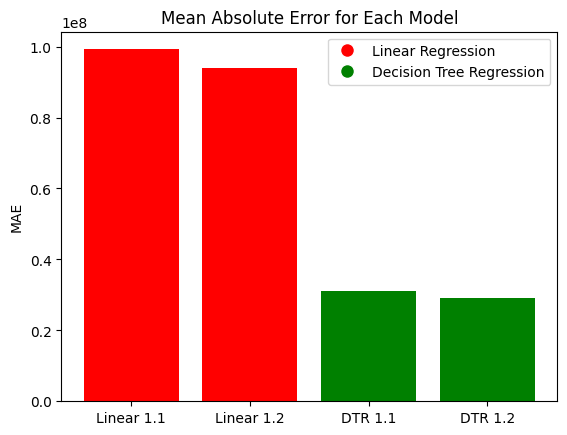

In [26]:
mae_values = [mean(absolute(score_1_1)), mean(absolute(score_1_2)), mean(absolute(score_2_1)), mean(absolute(score_2_2))]
models = ['Linear 1.1', 'Linear 1.2', 'DTR 1.1', 'DTR 1.2']

plt.bar(models, mae_values, color=['red', 'red', 'green', 'green'])
plt.ylabel('MAE')
plt.title('Mean Absolute Error for Each Model')
legend_labels = ['Linear Regression', 'Decision Tree Regression']
legend_colors = ['red', 'green']
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_patches, loc='upper right')
plt.show()

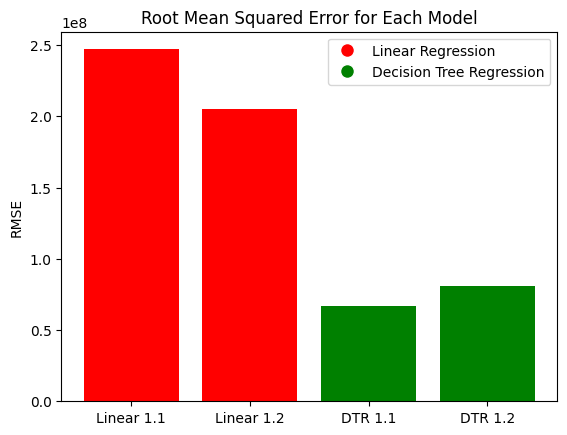

In [27]:
rmse_values = [RMSE_1_1, RMSE_1_2, RMSE_2_1, RMSE_2_2]
models = ['Linear 1.1', 'Linear 1.2', 'DTR 1.1', 'DTR 1.2']

plt.bar(models, rmse_values, color=['red', 'red', 'green', 'green'])
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error for Each Model')
legend_labels = ['Linear Regression', 'Decision Tree Regression']
legend_colors = ['red', 'green']
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_patches, loc='upper right')
plt.show()

So we will choose model 2.1

## Evaluation

Re-training

In [28]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model_eva1 = LinearRegression()
model_eva1.fit(X_final_1_train, y_train)

print("Coef: ", model_eva1.coef_)
print("Intercept: ", model_eva1.intercept_)
score_eva = cross_val_score(model_eva1, X_final_1_test, y_test, scoring = "neg_mean_absolute_error", cv=kf)
print("MAE of new model: ", mean(absolute(score_eva)))

Coef:  [ 1.10830349 -0.43387681]
Intercept:  -1951152.0940878391
MAE of new model:  110949272.73288557


In [29]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model_eva2 = DecisionTreeRegressor(max_depth=10000000, max_features=None)
model_eva2.fit(X_final_1_train, y_train)

print("Importance: ", model_eva2.feature_importances_)

score_eva = cross_val_score(model_eva2, X_final_1_test, y_test, scoring = "neg_mean_absolute_error", cv=kf)
print("MAE of new model: ", mean(absolute(score_eva)))

Importance:  [9.99059118e-01 9.40881536e-04]
MAE of new model:  43323008.8389027


## Results analysis

Here is the MAE of the whole train set, which means we include all feature to the model. It can be seen as the avg MAE.

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model_all = DecisionTreeRegressor(max_depth=10000000, max_features=None)
model_all.fit(X_train, y_train)

score_all = cross_val_score(model_all, X_test, y_test, scoring = "neg_mean_absolute_error", cv=kf)
print("Mean of this model: ", mean(absolute(score_all)))

Mean of this model:  54995829.94221532


Here, as we can see, MAE of this model is less than MAE of whole feature.

## Conclusion

- We can combine various feature for training our model to predict a specific feature.
- By sorting feature's correlation, we can choose some weighty feature, thus, our precise is higher.
- Decision Tree can model complex and nonlinear relationships in the data more flexibly than Linear Regression. If the data contains complex and nonlinear patterns, Decision Tree may perform better.
- Linear Regression is a linear model, so it tends to work better for linear relationships. If the data has complex and nonlinear relationships, Linear Regression may not be powerful enough to model them.
- The performance of Decision Tree and Linear Regression also depends on the characteristics of the data.

<div style="text-align: left; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Clustering
</div>

<font color=lightgreen>**Context**</font>: In this section, KMeans and GaussianMixture are choosen

<font color=lightgreen>**Question**</font>: Training a model to cluster the hospital (small, medium, large)

<font color=lightgreen>**Overall**</font>: We will train 02 models and compare them.

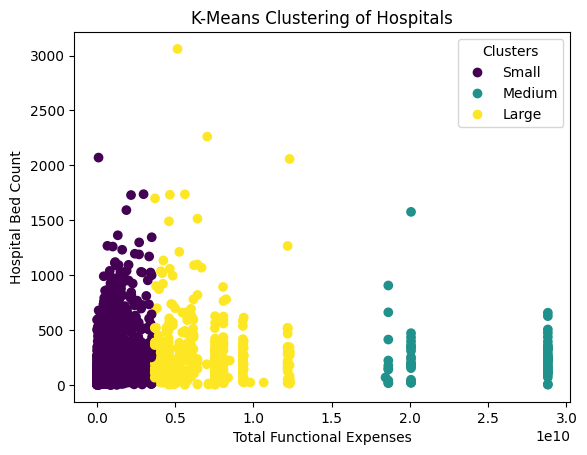

In [31]:
clustered_data_1 = ori_data.copy()
X_cluster = clustered_data_1[['tot_func_exp', 'hospital_bed_count']]

n_clusters = 3
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_model.fit(X_cluster)
labels = kmeans_model.labels_
clustered_data_1['cluster_label'] = labels

label_mapping = {0: 'Small', 1: 'Medium', 2: 'Large'}
clustered_data_1['cluster_label'] = clustered_data_1['cluster_label'].map(label_mapping)

scatter = plt.scatter(X_cluster['tot_func_exp'], X_cluster['hospital_bed_count'], c=labels, cmap='viridis', label='Cluster Label')
plt.title('K-Means Clustering of Hospitals')
plt.xlabel('Total Functional Expenses')
plt.ylabel('Hospital Bed Count')

legend_labels = [label_mapping[label] for label in sorted(set(labels))]
plt.legend(handles=scatter.legend_elements()[0], title="Clusters", labels=legend_labels)

plt.show()


c:\Users\tttoa\anaconda3\envs\min_ds-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tttoa\anaconda3\envs\min_ds-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tttoa\anaconda3\envs\min_ds-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tttoa\anaconda3\envs\min_ds-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

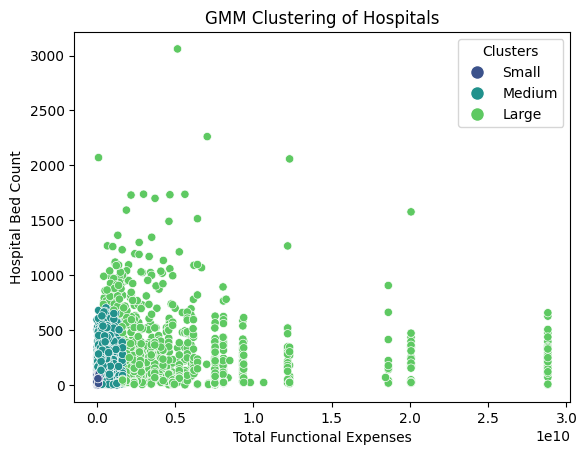

In [32]:
clustered_data_2 = ori_data.copy()

X_cluster = clustered_data_2[['tot_func_exp', 'hospital_bed_count']]

n_components = 3  
gmm_model = GaussianMixture(n_components=n_components, random_state=42)

gmm_model.fit(X_cluster)

labels_gmm = gmm_model.predict(X_cluster)
clustered_data_2['cluster_label'] = labels_gmm

label_mapping = {0: 'Small', 1: 'Medium', 2: 'Large'}
clustered_data_2['cluster_label'] = clustered_data_2['cluster_label'].map(label_mapping)

scatter = sns.scatterplot(x='tot_func_exp', y='hospital_bed_count', hue='cluster_label', data=clustered_data_2, palette='viridis')
plt.title('GMM Clustering of Hospitals')
plt.xlabel('Total Functional Expenses')
plt.ylabel('Hospital Bed Count')

legend_labels = [label_mapping[label] for label in sorted(set(labels_gmm))]
legend_colors = sns.color_palette('viridis', n_colors=n_components)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors], title="Clusters", labels=legend_labels)

plt.show()

In [33]:
def count_cluster_occurrences(cluster_labels):
    label_counts = Counter(cluster_labels)
    s = label_counts.get('Small', 0)
    m = label_counts.get('Medium', 0)
    l = label_counts.get('Large', 0)

    return s, m ,l

result1 = count_cluster_occurrences(clustered_data_1['cluster_label'])
print("Kmeans: ", result1)
result2 = count_cluster_occurrences(clustered_data_2['cluster_label'])
print("GMM: ", result2)

Kmeans:  (3016, 69, 402)
GMM:  (1258, 807, 1422)


## Conclusion

- Overall, Kmeans's plot is biased.
- K-Means is a simple and fast clustering method, but it may not truly capture heterogeneity inherent in Cloud workloads
- Gaussian Mixture Models can discover complex patterns and group them into cohesive, homogeneous components that are close representatives of real patterns within the data set.
- Non-uniform Distribution:
    + K-Means assumes that clusters are spherical and of equal size, making it unable to model clusters with different shapes and sizes.
    + GMM can model data with clusters of non-uniform shapes and sizes by using different Gaussian distribution functions for each cluster.
- Probability Modeling Capability:
    + GMM not only provides information about which cluster data belongs to but also about the certainty (probability) of a data point belonging to each cluster. This is useful when there is uncertainty about the clustering of a specific data point.
    + K-Means only provides information about which cluster each data point belongs to without indicating any level of certainty.
- Dealing with Non-Spherical Clusters:
    + GMM can model clusters with more complex shapes, while K-Means is generally more effective for spherical clusters.
- Soft Assignment:
    + GMM allows assigning a data point to all clusters with different weights, while K-Means assigns each data point to only one cluster.
This helps GMM handle well overlapping regions between clusters.
- In conclusion, in many cases, especially when dealing with complex and non-conforming data, GMM may be a better choice than K-Means. However, both methods have their own advantages and disadvantages, and the choice depends on the specific characteristics of the data and the goals of the problem.

<div style="text-align: left; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Classification
</div>

<font color=lightgreen>**Context**</font>: In this section, RandomForestClassifier are choosen

<font color=lightgreen>**Question**</font>: Training a model to classify a hospital.

<font color=lightgreen>**Overall**</font>: We will train a model and evaluate it.

In [34]:
# Import thư viện
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

x_RFC = clustered_data_2[['urban_location_f', 'tot_func_exp']]
x_RFC.loc[x_RFC["urban_location_f"] == "Y", "urban_location_f"] = 1
x_RFC.loc[x_RFC["urban_location_f"] == "N", "urban_location_f"] = 0

y_RFC = clustered_data_2['cluster_label']
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_RFC, X_test_RFC, y_train_RFC, y_test_RFC = train_test_split(x_RFC, y_RFC, test_size=0.2, random_state=42)

rf_model.fit(X_train_RFC, y_train_RFC)


y_pred_rf = rf_model.predict(X_test_RFC)


accuracy_rf = accuracy_score(y_test_RFC, y_pred_rf)
report_rf = classification_report(y_test_RFC, y_pred_rf)

print(f'Accuracy (Random Forest): {accuracy_rf}')
print('Classification Report (Random Forest):\n', report_rf)


Accuracy (Random Forest): 0.8882521489971347
Classification Report (Random Forest):
               precision    recall  f1-score   support

       Large       0.87      0.86      0.87       293
      Medium       0.94      0.94      0.94       145
       Small       0.88      0.90      0.89       260

    accuracy                           0.89       698
   macro avg       0.90      0.90      0.90       698
weighted avg       0.89      0.89      0.89       698



## Conclusion

- Overall, the performace of this model is acceptable with the accuracy is roughly 0.888
- To be specific, the precisions of Large, Medium and Small are high, over 0.85. In addition, the statistics of support are also.
- Note that the report can vary, this is my report after over 10-time running.